# Modeling 2: Create a User Defined Model using astropy.modeling

## Authors
Rocio Kiman, Lia Corrales, Zé Vinícius, Stephanie T. Douglas

## Learning Goals
* Define a new model with `astropy` 
* Identify cases were a user-defined model could be useful
* Define models in two different ways:
    * Compound models
    * Custom models

This tutorial assumes the student knows how to fit data using `astropy.modeling`. This topic is covered in the [Models-Quick-Fit tutorial](http://www.astropy.org/astropy-tutorials/rst-tutorials/Models-Quick-Fit.html).

## Keywords
modeling, FITS, astrostatistics, matplotlib, model fitting, error bars, scatter plots

## Summary
In this tutorial, we will learn how to define a new model in two ways: with a compound model and with a custom model.

<div class="alert alert-info">

**Note:** This tutorial assumes you have already gone through 
    [Modeling 1](http://www.astropy.org/astropy-tutorials/rst-tutorials/Models-Quick-Fit.html),
    which provides an introduction to `astropy.modeling`
    

</div>

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model
from astropy.modeling import Fittable1DModel, Parameter
from astroquery.sdss import SDSS

### Fit an emission line in a stellar spectrum

M dwarfs are low mass stars (less than half of the mass of the sun). Currently we do not understand completely the physics inside low mass stars because they do not behave the same way higher mass stars do. For example, they stay magnetically active longer than higher mass stars. One way to measure magnetic activity is the height of the [$H\alpha$](https://en.wikipedia.org/wiki/H-alpha) emission line. It is located at $6563$ Angstroms at the spectrum. 

Let's search for a spectrum of an M dwarf in the Sloan Digital Sky Survey (SDSS). First, we are going to look for the spectrum in the [SDSS database](https://dr12.sdss.org/basicSpectra). SDSS has a particular way to identify the stars it observes: it uses three numbers: Plate, Fiber and MJD (Modified Julian Date). The star we are going to use has:
* Plate: 1349
* Fiber: 216
* MJD: 52797

So go ahead, put this numbers in the website and click on Plot to visualize the spectrum. Try to localize the $H\alpha$ line. 

We could download the spectrum by hand from this website, but we are going to import it using the [SDSSClass](http://astroquery.readthedocs.io/en/latest/api/astroquery.sdss.SDSSClass.html) from [`astroquery.sdss`](https://astroquery.readthedocs.io/en/latest/sdss/sdss.html#module-astroquery.sdss). We can get the spectrum using the plate, fiber and mjd in the following way:

In [2]:
spectrum = SDSS.get_spectra(plate=1349, fiberID=216, mjd=52797)[0]

#### Now that we have the spectrum...
One way to check what is inside the fits file `spectrum` is the following:

In [3]:
spectrum[1].columns

ColDefs(
    name = 'flux'; format = 'E'
    name = 'loglam'; format = 'E'
    name = 'ivar'; format = 'E'
    name = 'and_mask'; format = 'J'
    name = 'or_mask'; format = 'J'
    name = 'wdisp'; format = 'E'
    name = 'sky'; format = 'E'
    name = 'model'; format = 'E'
)

To plot the spectrum we need the flux as a function of wavelength (usually called lambda or $\lambda$). Note that the wavelength is in log scale: loglam, so we calculate $10^\lambda$ to remove this scale.

In [4]:
flux = spectrum[1].data['flux']
lam = 10**(spectrum[1].data['loglam'])

To find the units for flux and wavelength, we look in `fitsfile[0].header`.

FITS standard requires that the header keyword 'bunit' or 'BUNIT' contains the physical units of the array values. That's where we'll find the flux units. 

In [5]:
#Units of the flux
units_flux = spectrum[0].header['bunit']
print(units_flux)

1E-17 erg/cm^2/s/Ang


Different sources will definite wavelength information differently, so we need to check the documentation. For example, this [SDSS tutorial](https://www.sdss.org/dr12/tutorials/quicklook/#python) tells us what header keyword to look at.

In [6]:
#Units of the wavelegth
units_wavelength_full = spectrum[0].header['WAT1_001']
print(units_wavelength_full)

wtype=linear label=Wavelength units=Angstroms


We are going to select only the characters of the unit we care about: Angstroms

In [7]:
units_wavelength = units_wavelength_full[36:]
print(units_wavelength)

Angstroms


Now we are ready to plot the spectrum with all the information.

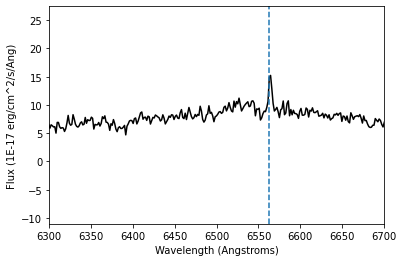

In [8]:
plt.plot(lam, flux, color='k')
plt.xlim(6300,6700)
plt.axvline(x=6563, linestyle='--')
plt.xlabel('Wavelength ({})'.format(units_wavelength))
plt.ylabel('Flux ({})'.format(units_flux))
plt.show()


We just plotted our spectrum! Check different ranges of wavelength to see how the full spectrum looks like in comparison to the one we saw before.

## Fit an Emission Line with a Gaussian Model

The blue dashed line marks the $H\alpha$ emission line. We can tell this is an active star because it has a strong emission line.

Now, we would like to measure the height of this line. Let's use `astropy.modeling` to fit a gaussian to the $H\alpha$ line. We are going to initialize a gaussian model at the position of the $H\alpha$ line. The idea is that the gaussian amplitude will tell us the height of the line.

In [9]:
gausian_model = models.Gaussian1D(1, 6563, 10)
fitter = fitting.LevMarLSQFitter()
gaussian_fit = fitter(gausian_model, lam, flux)

Let's plot the results.

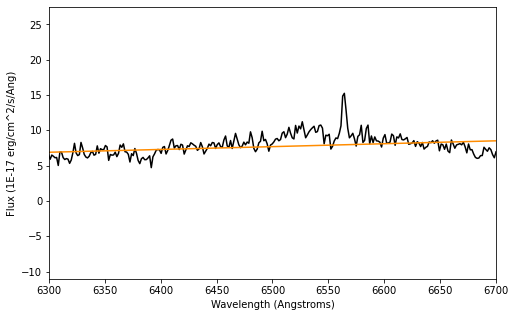

In [10]:
plt.figure(figsize=(8,5))
plt.plot(lam, flux, color='k')
plt.plot(lam, gaussian_fit(lam), color='darkorange')
plt.xlim(6300,6700)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux ({})'.format(units_flux))
plt.show()

We can see the fit is not doing a good job. Let's print the parameters of this fit:

In [11]:
print(gaussian_fit)

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean             stddev     
    ------------------ ----------------- -----------------
    16.750706286489784 9456.749529382625 2368.395705667002


## Exercise 

Go back to the previous plot and try to make the fit work. Note: **Do not spend more than 10 minutes** in this exercise. A couple of ideas to try: 
* Is it not working because of the model we chose to fit? You can find more models to use [here](http://docs.astropy.org/en/stable/modeling/#module-astropy.modeling.functional_models).
* Is it not working because of the fitter we chose?
* Is it not working because of the range of data we are fitting? 
* Is it not working because how we are plotting the data? 

# Compound models

One model is not enough to make this fit work. We need to combine a couple of models to make a [compound model](http://docs.astropy.org/en/stable/modeling/#compound-models) in `astropy`. The idea is that we can add, divide or multiply models that already exist in [astropy.modeling](http://docs.astropy.org/en/stable/modeling/#models-and-fitting-astropy-modeling) and fit the compound model to our data.

For our problem we are going to combine the gaussian with a polynomial of degree 1 to account for the background spectrum close to the $H\alpha$ line. Take a look at the plot we made before to convince yourself that this is the case.

Now let's make our compound model!

In [12]:
compound_model = models.Gaussian1D(1, 6563, 10) + models.Polynomial1D(degree=1)

After this point, we fit the data in exactly the same way as before, except we use a compound model instead of the gaussian model.

In [13]:
fitter = fitting.LevMarLSQFitter()
compound_fit = fitter(compound_model, lam, flux)

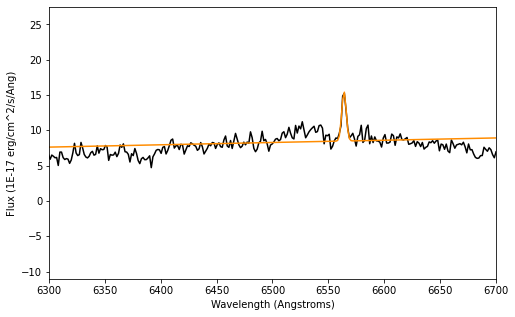

In [14]:
plt.figure(figsize=(8,5))
plt.plot(lam, flux, color='k')
plt.plot(lam, compound_fit(lam), color='darkorange')
plt.xlim(6300,6700)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux ({})'.format(units_flux))
plt.show()

It works! Let's take a look to the fit we just made. 

In [15]:
print(compound_fit)

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian1D(amplitude=7.02089174, mean=6564.13631715, stddev=1.97761475)>

    [1]: <Polynomial1D(1, c0=-12.79335619, c1=0.00323995)>
Parameters:
      amplitude_0          mean_0      ...         c0_1                c1_1        
    ---------------- ----------------- ... ------------------- --------------------
    7.02089174399097 6564.136317149307 ... -12.793356186324056 0.003239952053201843


Let's print all the parameters in a fancy way:

In [16]:
for x,y in zip(compound_fit.param_names, compound_fit.parameters):
    print(x,y)

amplitude_0 7.02089174399097
mean_0 6564.136317149307
stddev_0 1.9776147549590108
c0_1 -12.793356186324056
c1_1 0.003239952053201843


We can see that the result includes all the fit parameters from the gaussian (mean, std and amplitude) and the two coefficients from the polynomial of degree 1. So now if we want to see just the amplitude:

In [17]:
compound_fit.amplitude_0

Parameter('amplitude', value=7.02089174399097)

**Conclusions:** What was the difference between the first simple Gaussian and the compound model? The linear model that we added up to the gaussian model allowed the base of the Gaussian fit to have a slope and a background level. Normal Gaussians go to zero at $\pm \inf$; this one doesn't. 

### Fixed or bounded model parameters
The mean value of the gaussian from our previous model indicates where the $H\alpha$ line is. In our fit result, we can tell that it is a little off from $6563$ Angstroms. One way to fix this is to fix some of the parameters of the model. In `astropy.modeling` these are called **[fixed parameters](http://docs.astropy.org/en/stable/api/astropy.modeling.Parameter.html#astropy.modeling.Parameter.fixed)**.

In [18]:
compound_model_fixed = models.Gaussian1D(1, 6563, 10) + models.Polynomial1D(degree=1)
compound_model_fixed.mean_0.fixed = True

Now let's use this new model with a fixed parameter to fit the data the same way we did before.

In [19]:
fitter = fitting.LevMarLSQFitter()
compound_fit_fixed = fitter(compound_model_fixed, lam, flux)

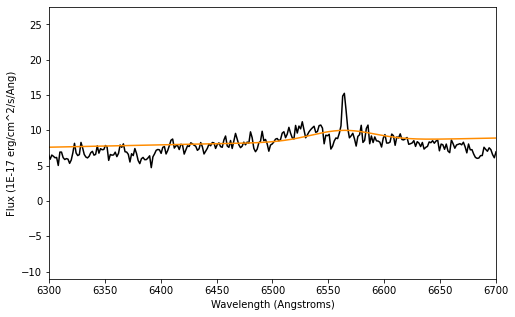

In [20]:
plt.figure(figsize=(8,5))
plt.plot(lam, flux, color='k')
plt.plot(lam, compound_fit_fixed(lam), color='darkorange')
plt.xlim(6300,6700)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux ({})'.format(units_flux))
plt.show()

In [21]:
print(compound_fit_fixed)

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian1D(amplitude=1.53257471, mean=6563., stddev=28.57847527)>

    [1]: <Polynomial1D(1, c0=-12.79103, c1=0.00323745)>
Parameters:
       amplitude_0     mean_0 ...         c0_1                 c1_1        
    ------------------ ------ ... ------------------- ---------------------
    1.5325747099688163 6563.0 ... -12.791030003382556 0.0032374486282497287


We can see in the plot that the height of the fit does not match the $H\alpha$ line height. What happend here is that we were too strict with the mean value, so we did not get a good fit. But the mean value is where we want it! Let's loosen this condition a little. Another thing we can do is to define a [**minimum and maximum value**](http://docs.astropy.org/en/stable/api/astropy.modeling.Parameter.html#astropy.modeling.Parameter.max) for the mean.

In [22]:
compound_model_bounded = models.Gaussian1D(1, 6563, 10) + models.Polynomial1D(degree=1)
delta = 0.5
compound_model_bounded.mean_0.max = 6563 + delta
compound_model_bounded.mean_0.min = 6563 - delta

fitter = fitting.LevMarLSQFitter()
compound_fit_bounded = fitter(compound_model_bounded, lam, flux)

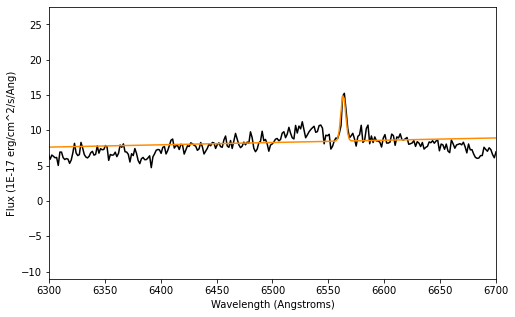

In [23]:
plt.figure(figsize=(8,5))
plt.plot(lam, flux, color='k')
plt.plot(lam, compound_fit_bounded(lam), color='darkorange')
plt.xlim(6300,6700)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux ({})'.format(units_flux))
plt.show()

In [24]:
print(compound_fit_bounded)

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian1D(amplitude=6.65730507, mean=6563.5, stddev=2.09182676)>

    [1]: <Polynomial1D(1, c0=-12.79336254, c1=0.00323995)>
Parameters:
       amplitude_0    mean_0 ...         c0_1                 c1_1        
    ----------------- ------ ... ------------------- ---------------------
    6.657305067137901 6563.5 ... -12.793362542827749 0.0032399500254038627


Better! By loosening the condition we added to the mean value, we got a better fit and the mean of the gaussian is closer to where we want it.

## Exercise
Modify the value of delta to change the minimum and maximum values for the mean of the gaussian. Look for:
* The better delta so the mean is closer to the real value of the $H\alpha$ line.
* What is the minimum delta for which the fit is still good according to the plot?

# Custom model

What should you do if you need a model that `astropy.modeling` doesn't provide? To solve that problem, Astropy has another tool called [custom model](http://docs.astropy.org/en/stable/modeling/new.html). Using this tool, we can create any model we want. 

We will describe two ways to create a custom model: 
* [basic](http://docs.astropy.org/en/stable/modeling/new.html#basic-custom-models)  
* [full](http://docs.astropy.org/en/stable/modeling/new.html#a-step-by-step-definition-of-a-1-d-gaussian-model)

We use the basic custom model when we need a simple function to fit and the full custom model when we need a more complex function. Let's use an example to understand each one of the custom models.

## Basic custom model

An **Exponential Model** is not provided by Astropy models. Let's see one example of basic custom model for this case. First, let's simulate a dataset that follows an exponential:

In [25]:
x1 = np.linspace(0,10,100)

a = 3
b = -2
c = 0
y1 = a*np.exp(b*x1+c)
y1 += np.random.normal(0., 0.2, x1.shape)
y1_err = np.ones(x1.shape)*0.2

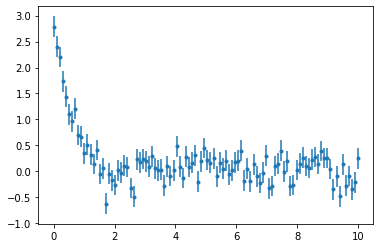

In [26]:
plt.errorbar(x1 , y1, yerr=y1_err, fmt='.')
plt.show()

We can define a simple custom model by specifying which parameters we want to fit.

In [27]:
@custom_model
def exponential(x, a=1., b=1., c=1.):
    '''
    f(x)=a*exp(b*x + c)
    '''
    return a*np.exp(b*x+c)

Now we have one more available model to use in the same way we fit data with `astropy.modeling`. 

In [28]:
exp_model = exponential(1.,-1.,1.)  
fitter = fitting.LevMarLSQFitter()
exp_fit = fitter(exp_model, x1, y1, weights = 1.0/y1_err**2)

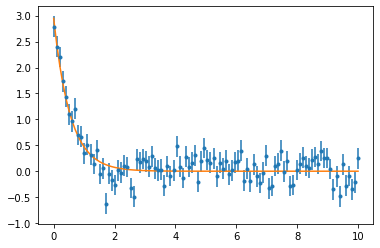

In [29]:
plt.errorbar(x1 , y1, yerr=y1_err, fmt='.')
plt.plot(x1, exp_fit(x1))
plt.show()

In [30]:
print(exp_fit)

Model: exponential
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
            a                   b                   c         
    ------------------ ------------------- -------------------
    2.5620254580035864 -1.8388649000002972 0.14011761181600843


The fit looks good in the plot. Let's check the parameters and the Reduced Chi Square value, which will give us information about the goodness of the fit.

In [31]:
def calc_reduced_chi_square(fit, x, y, yerr, N, n_free):
    '''
    fit (array) values for the fit
    x,y,yerr (arrays) data
    N total number of points
    n_free number of parameters we are fitting
    '''
    return 1.0/(N-n_free)*sum(((fit - y)/yerr)**2)

In [32]:
calc_reduced_chi_square(exp_fit(x1), x1, y1, y1_err, len(x1), 3)

1.3198103852802097

The Reduced Chi Square value is close to 1. Great! This means our fit is good, and we can corroborate it by comparing the values we got for the parameters and the ones we used to simulate the data.

**Note:** Fits of non-linear parameters (like in our example) are extremely dependent on initial conditions. Pay attention to the initial conditions you select.

## Exercise
Modify the initial conditions of the fit and check yourself the relation between the best fit parameters and the initial conditions for the previous example. You can check it by looking at the Reduced Chi Square value: if it gets closer to 1 the fit is better and vice versa. To compare the quality of the fits you can take note of the Reduced Chi Square value you get for each initial condition.

## Full custom model

What if we want to use a model from `astropy.modeling`, but with a different set of parameters? One example is the [Sine Model](http://docs.astropy.org/en/stable/api/astropy.modeling.functional_models.Sine1D.html#astropy.modeling.functional_models.Sine1D). It has a very particular definition of the frequency and phase. Let's define a new Sine function with a full custom model. Again, first let's create a simulated dataset.

In [33]:
x2 = np.linspace(0,10,100)
a = 3
b = 2
c = 4
d = 1
y2 = a*np.sin(b*x2+c)+d
y2 += np.random.normal(0., 0.5, x2.shape)
y2_err = np.ones(x2.shape)*0.3

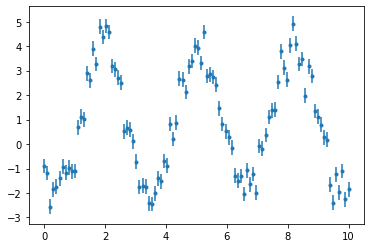

In [34]:
plt.errorbar(x2, y2, yerr=y2_err, fmt='.')
plt.show()

For the full custom model we can easily set the **derivative of the function**, which is used by different [fitters](http://docs.astropy.org/en/stable/modeling/#id21), for example the `LevMarLSQFitter()`.

In [35]:
class SineNew(Fittable1DModel):
    a = Parameter(default=1.)
    b = Parameter(default=1.)
    c = Parameter(default=1.)
    d = Parameter(default=1.)
        
    @staticmethod
    def evaluate(x, a, b, c, d):
        return a*np.sin(b*x+c)+d
    
    @staticmethod
    def fit_deriv(x, a, b, c, d):
        d_a = np.sin(b*x+c)
        d_b = a*np.cos(b*x+c)*x
        d_c = a*np.cos(b*x+c)
        d_d = np.ones(x.shape)
        return [d_a, d_b, d_c, d_d]

**Note** Defining default values for the fit parameters allows to define a model as `model=SineNew()`

We are going to fit the data with our **new model**. Once more, the fit is very **sensitive to the initial conditions** due to the non-linearity of the parameters.

In [36]:
sine_model = SineNew(a=4.,b=2.,c=4.,d=0.)  
fitter = fitting.LevMarLSQFitter()
sine_fit = fitter(sine_model, x2, y2, weights = 1.0/y2_err**2)

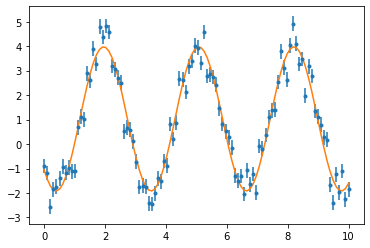

In [37]:
plt.errorbar(x2, y2, yerr=y2_err, fmt='.')
plt.plot(x2,sine_fit(x2))
plt.show()

In [38]:
print(sine_fit)

Model: SineNew
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
            a                  b                 c                  d         
    ------------------ ----------------- ------------------ ------------------
    2.9461494216441455 2.010092808410115 3.9263400060578517 1.0270488784337084


In [39]:
calc_reduced_chi_square(sine_fit(x2), x2, y2, y2_err, len(x2), 3)

3.021633553010704

The Reduced Chi Squared value is showing the same as the plot: this fit could be improved. The Reduced Chi Squared is not close to 1 and the fit is off by small phase.

## Exercise
Play with the initial values for the last fit and improve the Reduced Chi Squared value. 

**Note:** A fancy way of doing this would be to code a function which iterates over different initial conditions, optimizing the Reduced Chi Squared value. No need to do it here, but feel free to try.

## Exercise

Custom models are also useful when we want to fit an **unusual function** to our data. As an example, create a full custom model to fit the following data.

In [40]:
x3 = np.linspace(-2,3,100)
y3 = x3**2* np.exp(-0.5 * (x3)**3 / 2**2)
y3 += np.random.normal(0., 0.5, x3.shape)
y3_err = np.ones(x3.shape)*0.5

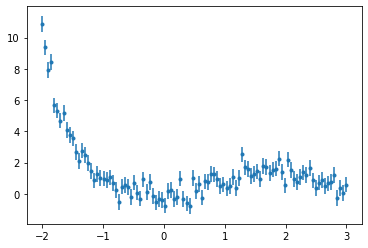

In [41]:
plt.errorbar(x3,y3,yerr=y3_err,fmt='.')
plt.show()